In [1]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [2]:
# Generate synthetic time series data
def generate_time_series(n_points=1000, freq=0.05, noise_level=0.1, trend=0.001):
    """
    Generate synthetic time series with trend, seasonality, and noise
    """
    time = np.arange(n_points)

    # Create trend and seasonal components
    trend_component = trend * time
    seasonal_component = np.sin(2 * np.pi * freq * time) + 0.5 * np.cos(4 * np.pi * freq * time)

    # Add some irregular patterns
    irregular_component = np.random.normal(0, noise_level, n_points)

    # Combine all components
    series = trend_component + seasonal_component + irregular_component

    return series

# Generate the time series
ts_data = generate_time_series(n_points=1000, freq=0.05, noise_level=0.1, trend=0.001)

# Create a DataFrame for easier handling
df = pd.DataFrame({
    'time': range(len(ts_data)),
    'value': ts_data
})

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 10 rows:")
print(df.head(10))
print("\nLast 10 rows:")
print(df.tail(10))
print(f"\nTime series statistics:")
print(f"Mean: {df['value'].mean():.4f}")
print(f"Std: {df['value'].std():.4f}")
print(f"Min: {df['value'].min():.4f}")
print(f"Max: {df['value'].max():.4f}")

Dataset shape: (1000, 2)

First 10 rows:
   time     value
0     0  0.549671
1     1  0.700699
2     2  0.809063
3     3  0.809811
4     4  0.527133
5     5  0.481586
6     6  0.710469
7     7  0.738252
8     8  0.703346
9     9  0.776781

Last 10 rows:
     time     value
990   990  1.510838
991   991  0.882318
992   992  0.534006
993   993 -0.038724
994   994 -0.461727
995   995 -0.533110
996   996 -0.179796
997   997  0.097559
998   998  0.507605
999   999  1.151750

Time series statistics:
Mean: 0.5014
Std: 0.8434
Min: -1.5871
Max: 1.8389


In [3]:
# Data preprocessing for LSTM
def create_sequences(data, seq_length):
    """
    Create input sequences and target values for LSTM
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Prepare the data
seq_length = 50  # Use 50 time steps to predict the next value
values = df['value'].values

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Create sequences
X, y = create_sequences(scaled_values, seq_length)

# Split into train and test sets (80-20 split)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)  # Add feature dimension
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

print("Training set shape:", X_train_tensor.shape)
print("Test set shape:", X_test_tensor.shape)
print("Number of sequences in training:", len(X_train))
print("Number of sequences in testing:", len(X_test))

Training set shape: torch.Size([760, 50, 1])
Test set shape: torch.Size([190, 50, 1])
Number of sequences in training: 760
Number of sequences in testing: 190


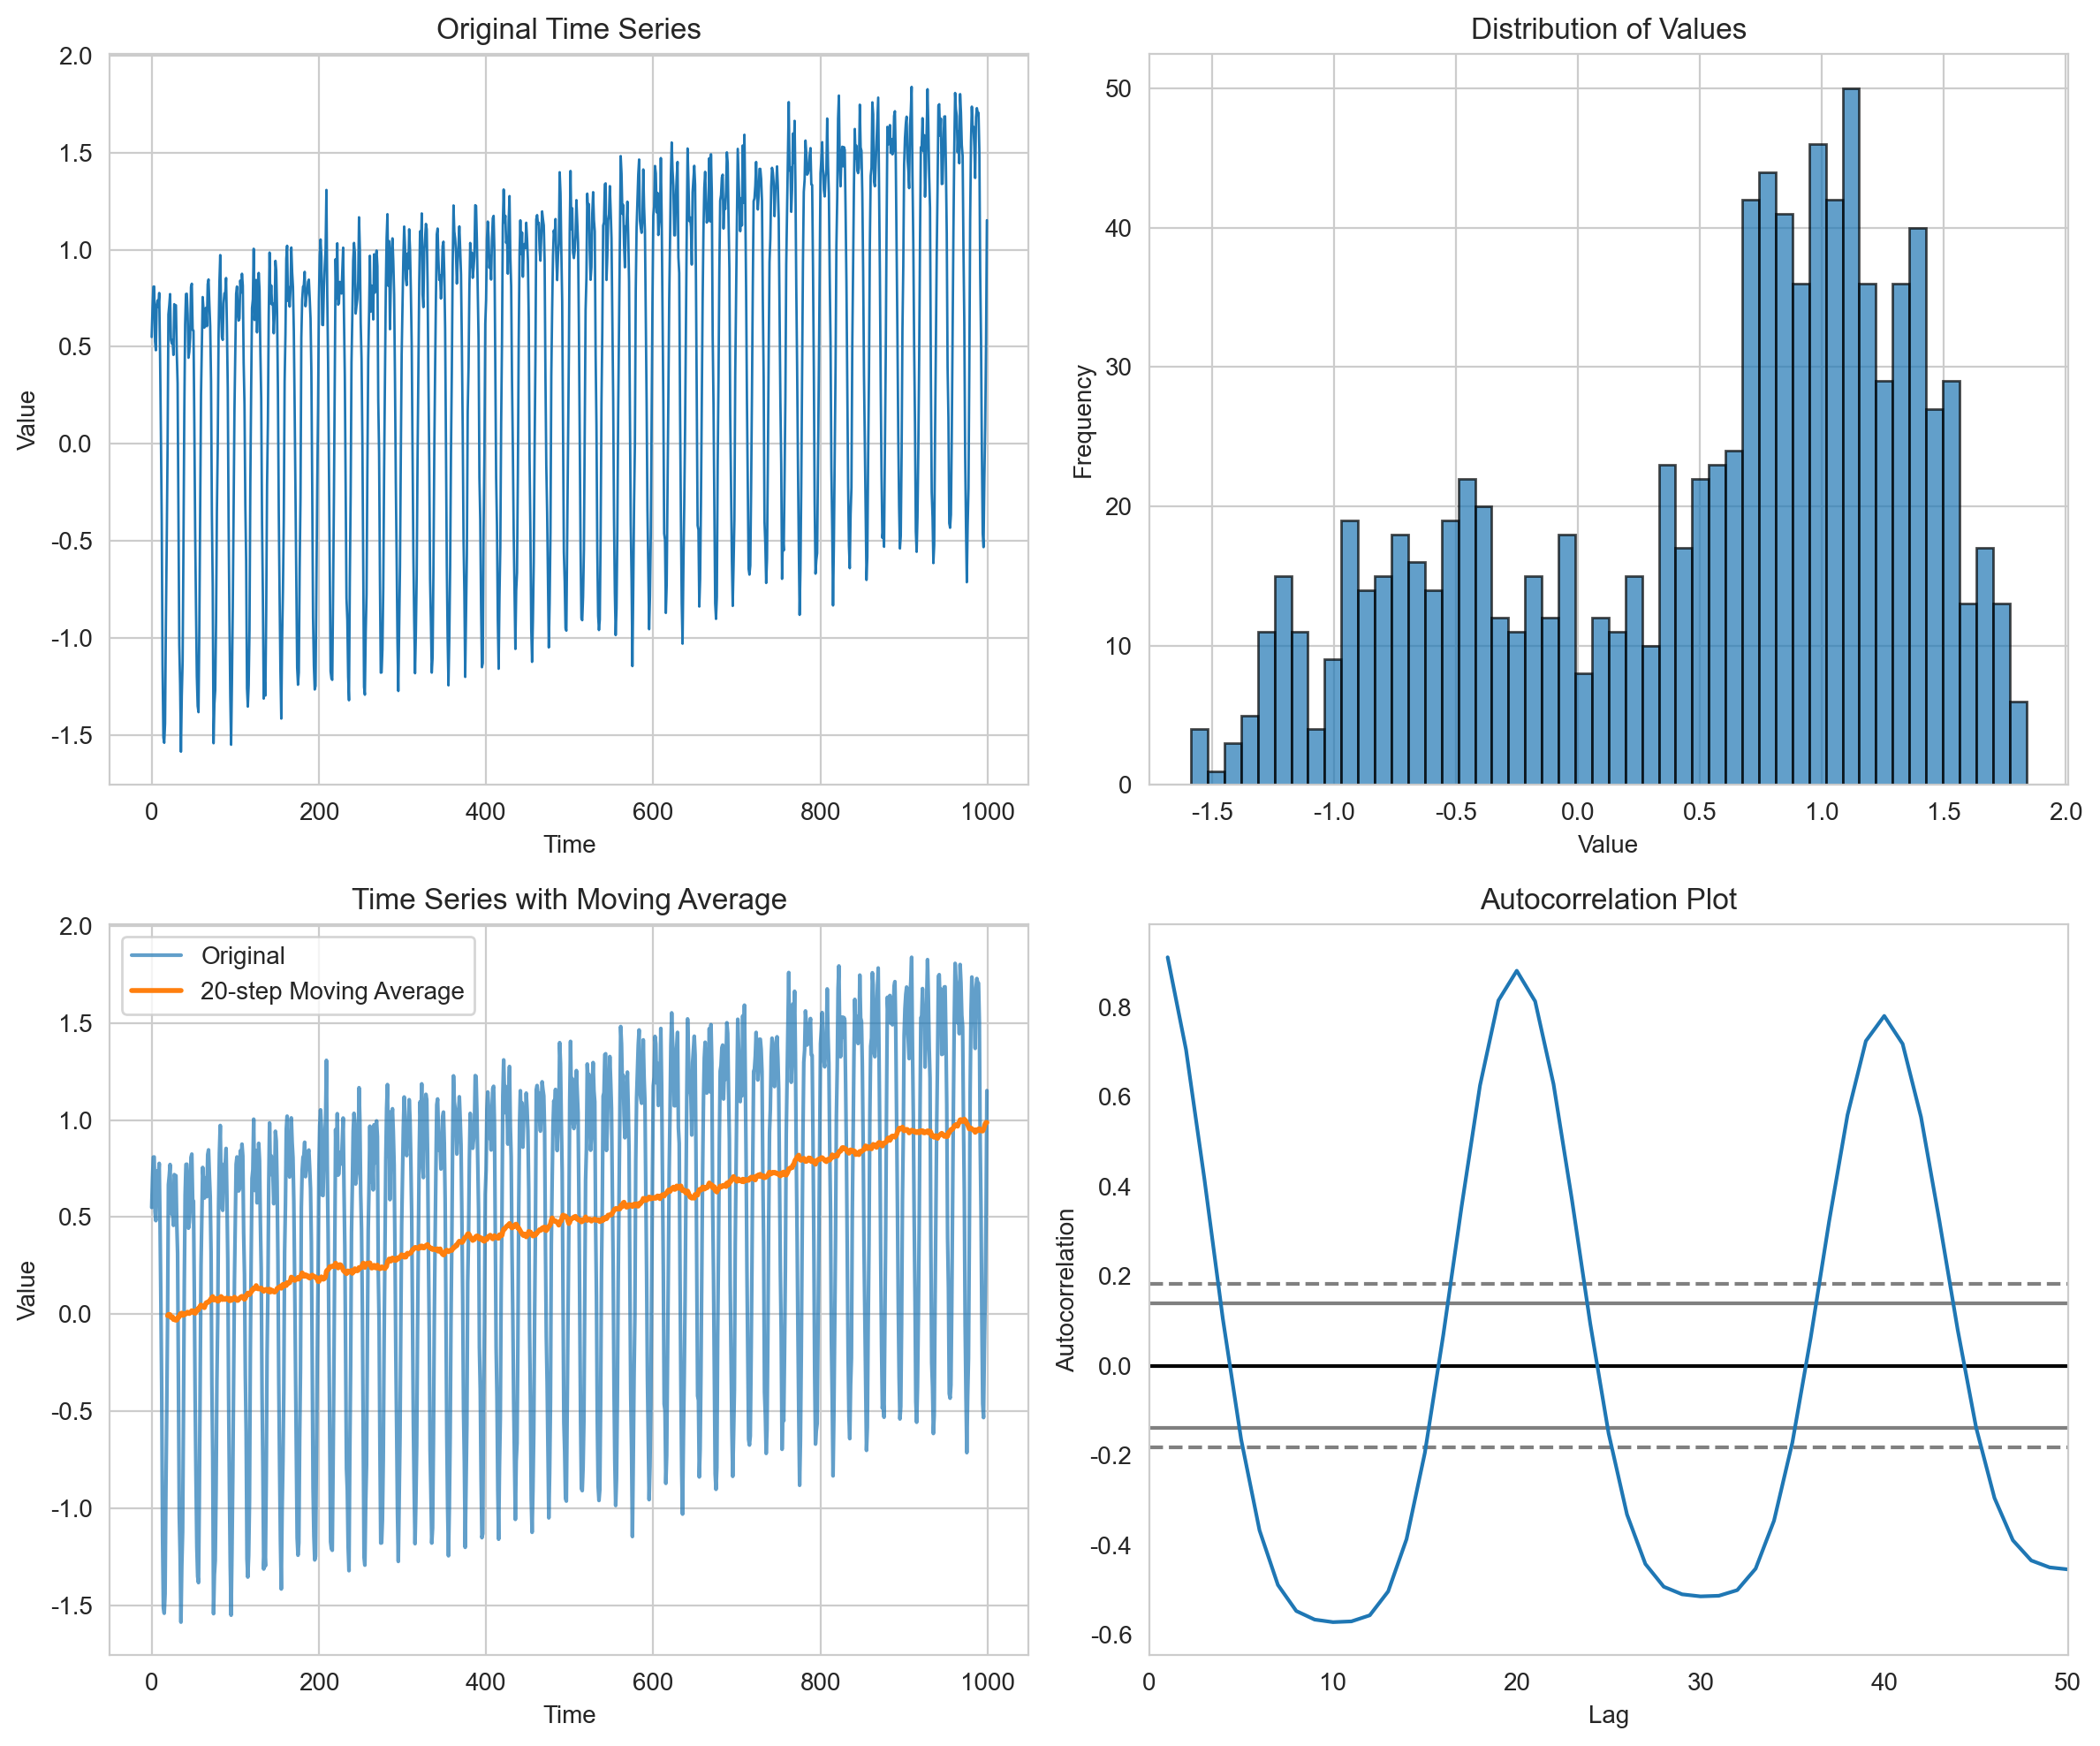

Sequence length: 50
Number of features per sequence: 1
First sequence (first 10 values): [0.62369998 0.6677836  0.69941395 0.69963254 0.61712112 0.60382654
 0.67063545 0.67874496 0.66855631 0.68999138]
Target for first sequence: 0.633255608663066


In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Original time series plot
axes[0,0].plot(df['time'], df['value'], linewidth=1)
axes[0,0].set_title('Original Time Series')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Value')

# Histogram of values
axes[0,1].hist(df['value'], bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Distribution of Values')
axes[0,1].set_xlabel('Value')
axes[0,1].set_ylabel('Frequency')

# Moving average
window_size = 20
df['moving_avg'] = df['value'].rolling(window=window_size).mean()
axes[1,0].plot(df['time'], df['value'], label='Original', alpha=0.7)
axes[1,0].plot(df['time'], df['moving_avg'], label=f'{window_size}-step Moving Average', linewidth=2)
axes[1,0].set_title('Time Series with Moving Average')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Value')
axes[1,0].legend()

# Autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['value'][:200], ax=axes[1,1])  # Limit for better visualization
axes[1,1].set_title('Autocorrelation Plot')
axes[1,1].set_xlim(0, 50)

plt.tight_layout()
plt.show()

# Show statistics about the sequences
print(f"Sequence length: {seq_length}")
print(f"Number of features per sequence: {X_train_tensor.shape[2]}")
print(f"First sequence (first 10 values): {X_train[0][:10]}")
print(f"Target for first sequence: {y_train[0]}")

In [5]:
# Define LSTM model
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(LSTMForecast, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2  # Add dropout for regularization
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))

        # Take the last output
        output = self.fc(lstm_out[:, -1, :])

        return output

# Initialize the model
input_size = 1  # Number of features per time step
hidden_size = 50  # Number of features in hidden state
num_layers = 2  # Number of LSTM layers
output_size = 1  # Number of outputs

model = LSTMForecast(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Display model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal number of parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
LSTMForecast(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

Total number of parameters: 31051


In [6]:
# Train the LSTM model
num_epochs = 100
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    train_losses.append(epoch_loss)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}')

print("Training completed!")

Epoch [20/100], Loss: 0.057942
Epoch [40/100], Loss: 0.058949
Epoch [60/100], Loss: 0.055063
Epoch [80/100], Loss: 0.052645
Epoch [100/100], Loss: 0.048214
Training completed!


In [7]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Predictions on test set
    test_predictions = model(X_test_tensor)
    test_predictions = test_predictions.numpy()

    # Predictions on training set for comparison
    train_predictions = model(X_train_tensor)
    train_predictions = train_predictions.numpy()

# Inverse transform the predictions and actual values
test_predictions_actual = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

train_predictions_actual = scaler.inverse_transform(train_predictions.reshape(-1, 1)).flatten()
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions_actual))
train_mae = mean_absolute_error(y_train_actual, train_predictions_actual)
test_mae = mean_absolute_error(y_test_actual, test_predictions_actual)
train_r2 = r2_score(y_train_actual, train_predictions_actual)
test_r2 = r2_score(y_test_actual, test_predictions_actual)

print("Model Performance Metrics:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Model Performance Metrics:
Training RMSE: 0.7474
Test RMSE: 0.8376
Training MAE: 0.6345
Test MAE: 0.7715
Training R²: 0.1769
Test R²: -0.0654


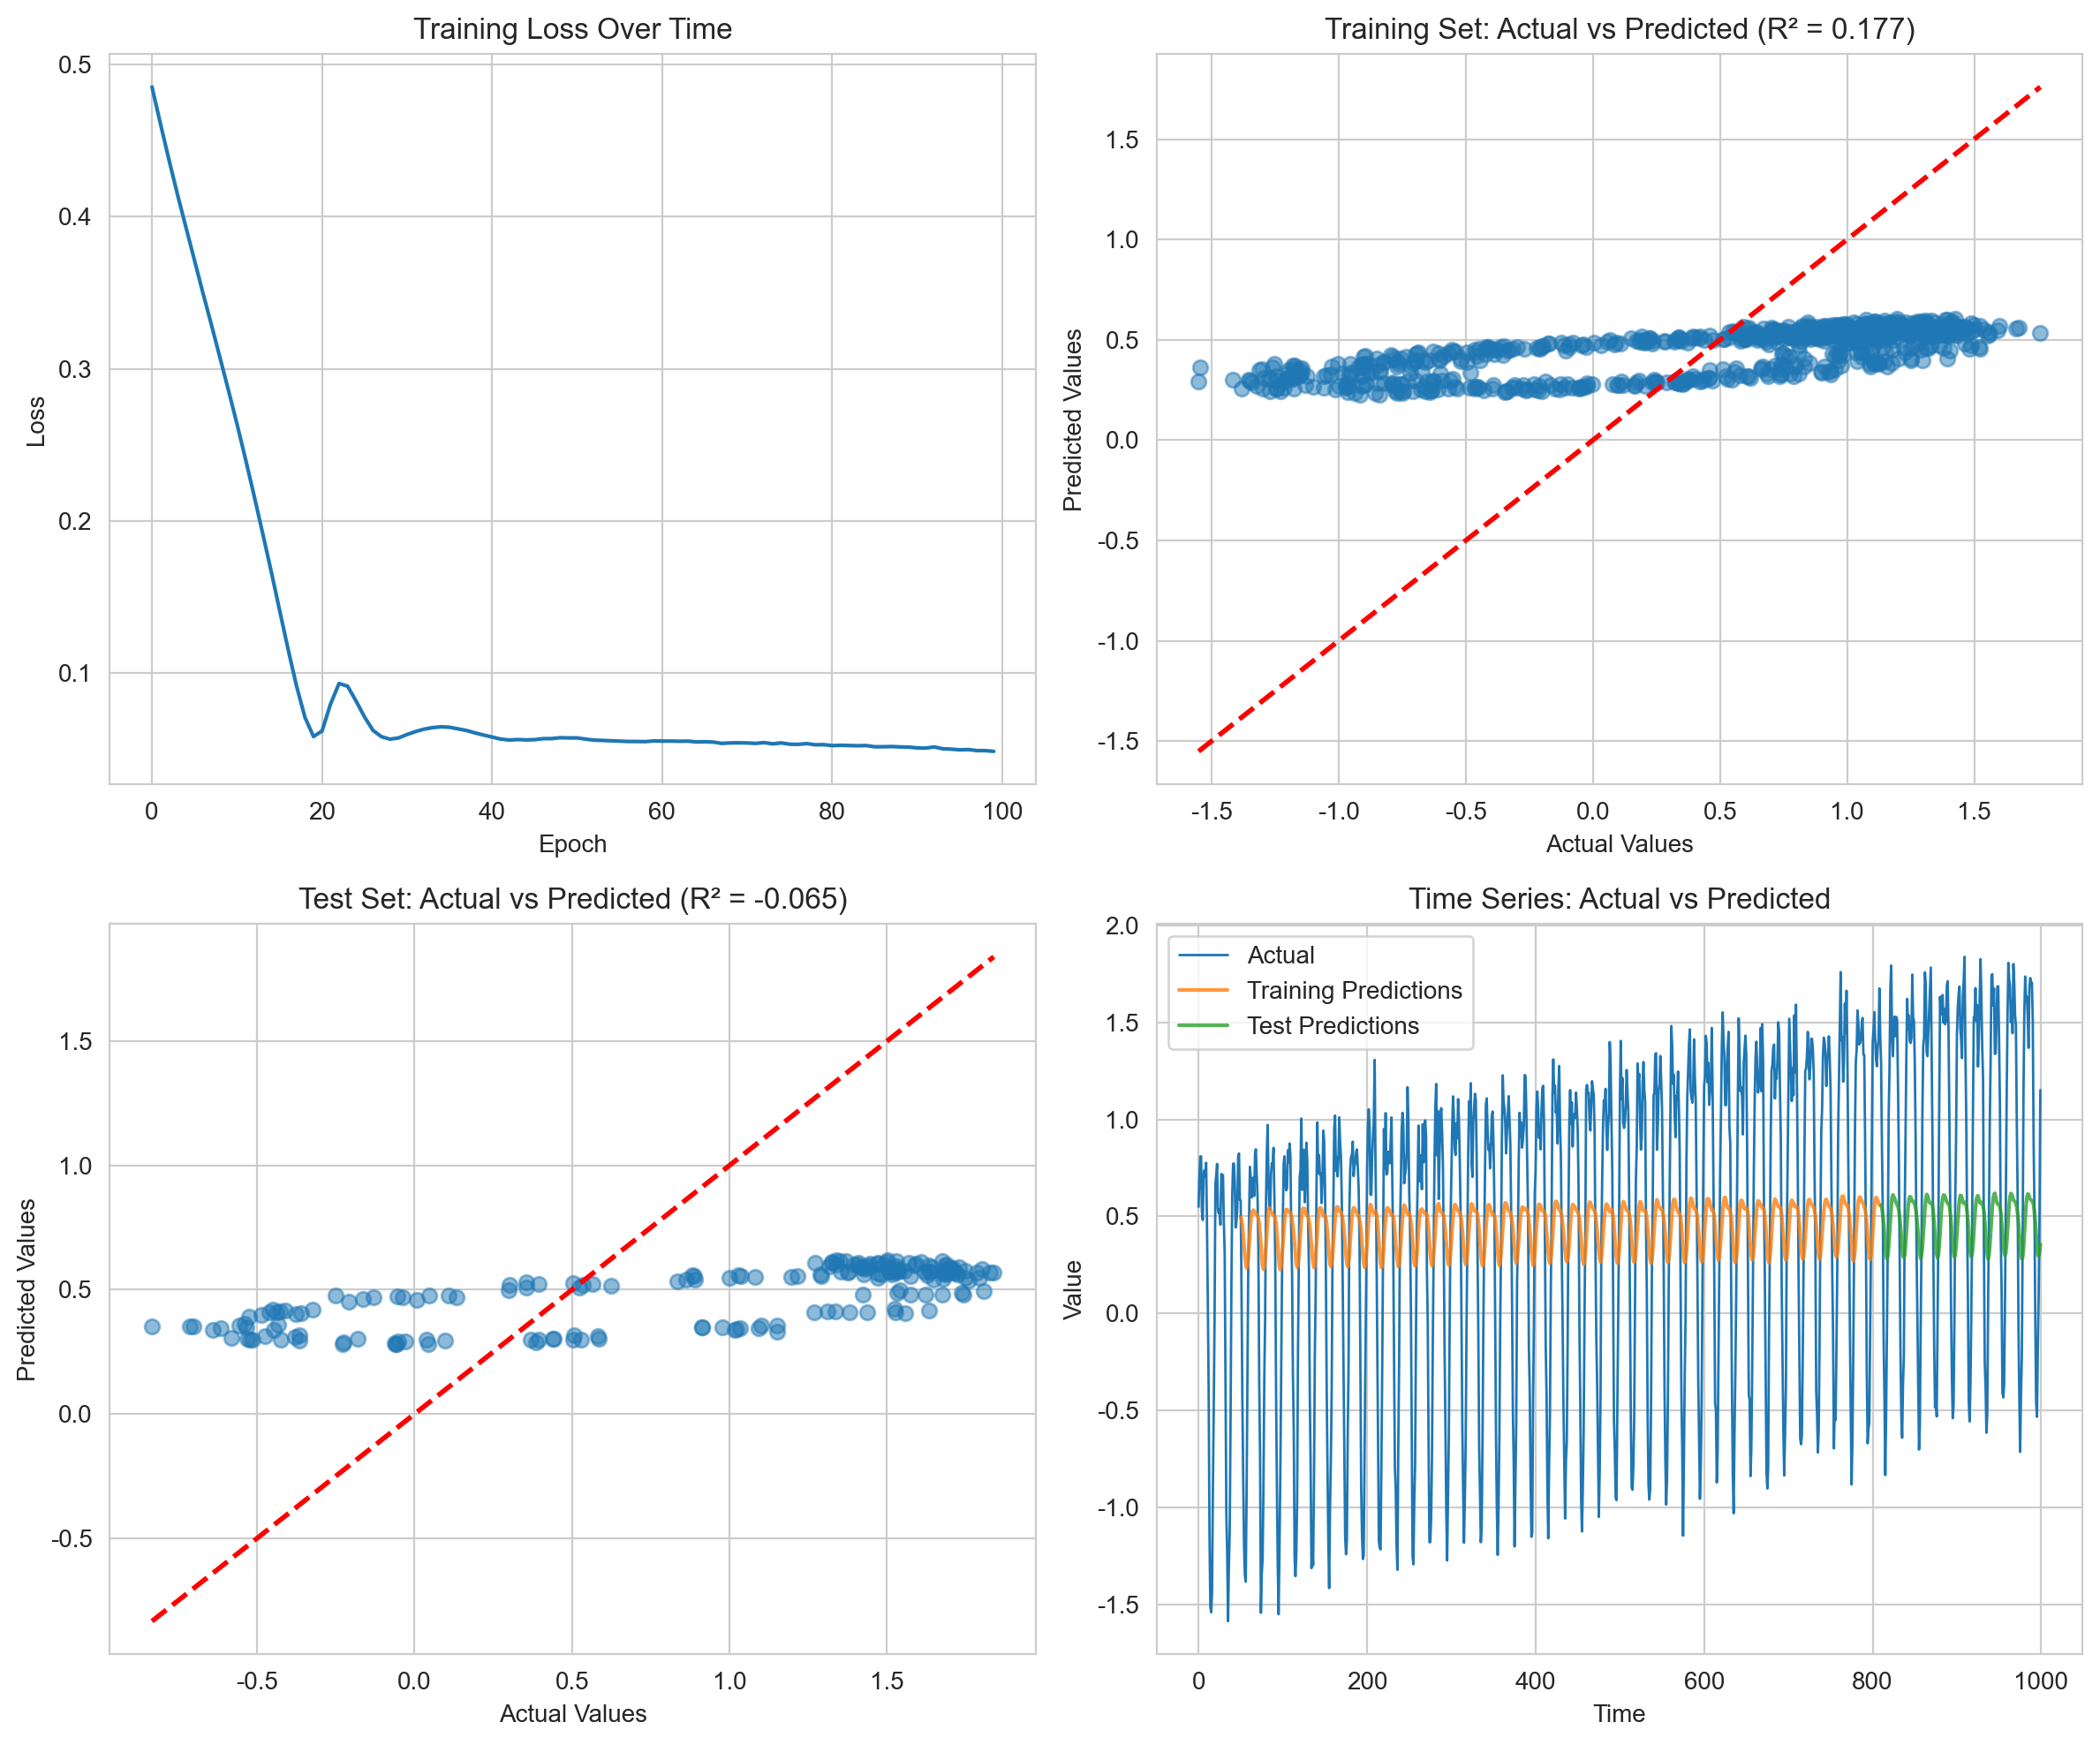

In [8]:
# Visualization of results
fig, axes = plt.subplots(2, 2)

# Training loss curve
axes[0,0].plot(train_losses)
axes[0,0].set_title('Training Loss Over Time')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')

# Actual vs Predicted on training set
axes[0,1].scatter(y_train_actual, train_predictions_actual, alpha=0.5)
axes[0,1].plot([y_train_actual.min(), y_train_actual.max()],
               [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Actual Values')
axes[0,1].set_ylabel('Predicted Values')
axes[0,1].set_title(f'Training Set: Actual vs Predicted (R² = {train_r2:.3f})')

# Actual vs Predicted on test set
axes[1,0].scatter(y_test_actual, test_predictions_actual, alpha=0.5)
axes[1,0].plot([y_test_actual.min(), y_test_actual.max()],
               [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title(f'Test Set: Actual vs Predicted (R² = {test_r2:.3f})')

# Time series plot comparing actual and predicted
# Prepare data for time series plot
# Get the original time series values
original_series = scaler.inverse_transform(scaled_values.reshape(-1, 1)).flatten()

# Create arrays for plotting
train_pred_full = np.full_like(original_series, np.nan)
test_pred_full = np.full_like(original_series, np.nan)

# Fill in the predictions at the right positions
train_start_idx = seq_length
train_end_idx = train_start_idx + len(train_predictions_actual)
train_pred_full[train_start_idx:train_end_idx] = train_predictions_actual

test_start_idx = train_end_idx
test_end_idx = test_start_idx + len(test_predictions_actual)
test_pred_full[test_start_idx:test_end_idx] = test_predictions_actual

axes[1,1].plot(df['time'], original_series, label='Actual', linewidth=1)
axes[1,1].plot(df['time'][train_start_idx:], train_pred_full[train_start_idx:],
               label='Training Predictions', alpha=0.8)
axes[1,1].plot(df['time'][test_start_idx:], test_pred_full[test_start_idx:],
               label='Test Predictions', alpha=0.8)
axes[1,1].set_title('Time Series: Actual vs Predicted')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Value')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [9]:
# Model interpretation and insights
print("LSTM Model Configuration:")
print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of layers: {num_layers}")
print(f"Output size: {output_size}")
print(f"Sequence length: {seq_length}")

print(f"\nPrediction Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"RMSE ratio (Test/Train): {test_rmse/train_rmse:.2f}")

# Calculate and display prediction statistics
print(f"\nPrediction Statistics:")
print(f"Mean of test predictions: {test_predictions_actual.mean():.2f}")
print(f"Std of test predictions: {test_predictions_actual.std():.2f}")
print(f"Mean of actual test values: {y_test_actual.mean():.2f}")
print(f"Std of actual test values: {y_test_actual.std():.2f}")

# Show some example predictions
print(f"\nExample Predictions (first 10 test samples):")
for i in range(min(10, len(y_test_actual))):
    print(f"  Actual: {y_test_actual[i]:.3f}, Predicted: {test_predictions_actual[i]:.3f}, "
          f"Error: {abs(y_test_actual[i] - test_predictions_actual[i]):.3f}")

LSTM Model Configuration:
Input size: 1
Hidden size: 50
Number of layers: 2
Output size: 1
Sequence length: 50

Prediction Performance:
Training RMSE: 0.7474
Test RMSE: 0.8376
RMSE ratio (Test/Train): 1.12

Prediction Statistics:
Mean of test predictions: 0.48
Std of test predictions: 0.11
Mean of actual test values: 0.89
Std of actual test values: 0.81

Example Predictions (first 10 test samples):
  Actual: 1.291, Predicted: 0.555, Error: 0.736
  Actual: 0.863, Predicted: 0.541, Error: 0.322
  Actual: 0.523, Predicted: 0.509, Error: 0.014
  Actual: -0.131, Predicted: 0.468, Error: 0.599
  Actual: -0.438, Predicted: 0.410, Error: 0.848
  Actual: -0.834, Predicted: 0.353, Error: 1.187
  Actual: -0.513, Predicted: 0.300, Error: 0.813
  Actual: -0.058, Predicted: 0.281, Error: 0.338
  Actual: 0.393, Predicted: 0.297, Error: 0.096
  Actual: 1.021, Predicted: 0.342, Error: 0.679
